In [ ]:
import os
import requests
from bs4 import BeautifulSoup

# Base URL
url = 'https://famprod.nwcg.gov/batchout/IMSRS_from_1990_to_2022/2021/'

# Fetch the webpage
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

# Find and download files
for link in soup.find_all('a'):
    file_url = link.get('href')
    if file_url and file_url.endswith(('csv', 'pdf', 'zip', 'txt')):  # Add or remove file types as needed
        file_name = os.path.join("C:\\Users\\smdur\\OneDrive\\Desktop\\IMSR\\rawdata\\", os.path.basename(file_url))
        with open(file_name, 'wb') as file:
            file.write(requests.get(url + file_url).content)

In [45]:
import os
import pandas as pd
from PyPDF2 import PdfReader
import re
from datetime import datetime, timedelta

# Create a new DataFrame with dates from January 1, 2021, to December 31, 2021
start_date = datetime(2021, 1, 1)
end_date = datetime(2021, 12, 31)
date_range = pd.date_range(start=start_date, end=end_date, freq='D')
gdf = pd.DataFrame(date_range, columns=['t'])

# Format the dates for file matching
gdf['formatted_t'] = gdf['t'].dt.strftime('%Y%m%d')

# Directory path where PDF files are stored
directory_path = "C:\\Users\\smdur\\OneDrive\\Desktop\\IMSR\\rawdata\\"
all_files = os.listdir(directory_path)

# Initialize empty DataFrame columns for text chunks
for i in range(1, 6):
    gdf[f'chunk{i}'] = None

# Define function to extract text between two markers
def extract_text_between_markers(text, start_marker, end_marker):
    regex_pattern = f"{re.escape(start_marker)}(.*?){re.escape(end_marker)}"
    matches = re.findall(regex_pattern, text, re.DOTALL)
    return matches

# Loop through all files in the directory
matched_files = []
for file_name in all_files:
    file_date = file_name[:8]  # Extract date from file name
    if file_date in gdf['formatted_t'].values:
        pdf_path = os.path.join(directory_path, file_name)
        matched_files.append(pdf_path)

        with open(pdf_path, 'rb') as pdf_file:
            pdf_reader = PdfReader(pdf_file)
            full_text = ''.join([page.extract_text() for page in pdf_reader.pages])


        markers = [
            ("National Preparedness Level ", "National Fire Activity"),
            ("Uncontained large fires", "NIMOs committed"), # not working
            ("Fires and Acres Yesterday", "Fires and Acres Year"), # not working 
            ("Fires and Acres Year", "Predictive Services Discussion"), # not working
            ("Predictive Services Discussion:", "http://www.")
        ]

        for idx, (start, end) in enumerate(markers, 1):
            chunk = extract_text_between_markers(full_text, start, end)
            gdf.loc[gdf['formatted_t'] == file_date, f'chunk{idx}'] = ' '.join(chunk)

# Display matched files and check chunks
print("Matched Files:", matched_files)
gdf[['formatted_t', 'chunk1', 'chunk2', 'chunk3', 'chunk4', 'chunk5']].dropna()

# Assuming 'gdf' is your GeoDataFrame
gdf['chunk1'] = gdf['chunk1'].str.replace(r'\n+', '', regex=True)

gdf['chunk1'] = gdf['chunk1'].replace('None', pd.NA).ffill()
gdf.loc[:6, 'chunk1'] = 1
gdf['chunk1'] = gdf['chunk1'].ffill()


gdf['chunk1'] = gdf['chunk1'].str.strip()
gdf['chunk1'] = gdf['chunk1'].astype('category')

subset_gdf = gdf[gdf['chunk5'].notna()]
subset_gdf


Matched Files: ['C:\\Users\\smdur\\OneDrive\\Desktop\\IMSR\\rawdata\\20210108IMSR.pdf', 'C:\\Users\\smdur\\OneDrive\\Desktop\\IMSR\\rawdata\\20210115IMSR.pdf', 'C:\\Users\\smdur\\OneDrive\\Desktop\\IMSR\\rawdata\\20210122IMSR.pdf', 'C:\\Users\\smdur\\OneDrive\\Desktop\\IMSR\\rawdata\\20210129IMSR.pdf', 'C:\\Users\\smdur\\OneDrive\\Desktop\\IMSR\\rawdata\\20210205IMSR.pdf', 'C:\\Users\\smdur\\OneDrive\\Desktop\\IMSR\\rawdata\\20210212IMSR.pdf', 'C:\\Users\\smdur\\OneDrive\\Desktop\\IMSR\\rawdata\\20210219IMSR.pdf', 'C:\\Users\\smdur\\OneDrive\\Desktop\\IMSR\\rawdata\\20210226IMSR.pdf', 'C:\\Users\\smdur\\OneDrive\\Desktop\\IMSR\\rawdata\\20210312IMSR.pdf', 'C:\\Users\\smdur\\OneDrive\\Desktop\\IMSR\\rawdata\\20210319IMSR.pdf', 'C:\\Users\\smdur\\OneDrive\\Desktop\\IMSR\\rawdata\\20210326IMSR.pdf', 'C:\\Users\\smdur\\OneDrive\\Desktop\\IMSR\\rawdata\\20210402IMSR.pdf', 'C:\\Users\\smdur\\OneDrive\\Desktop\\IMSR\\rawdata\\20210405IMSR.pdf', 'C:\\Users\\smdur\\OneDrive\\Desktop\\IMSR\\rawd

,t,formatted_t,chunk1,chunk2,chunk3,chunk4,chunk5
7,2021-01-08,20210108,1,:*** 0 \nArea Command teams committed: 0 \n,,-to-Date (by Protection): \nArea BIA BLM ...,Upper -level ridging will dominate the weath...
14,2021-01-15,20210115,1,:*** 5 \nArea Command teams committed: 0 \n,,-to-Date (by Protection): \nArea BIA BLM ...,Offshore flow will continue across southe...
21,2021-01-22,20210122,1,:*** 4 \nArea Command teams committed: 0 \n,,-to-Date (by Protection): \nArea BIA BLM ...,The upper -level ridge that has been mostl...
28,2021-01-29,20210129,1,:*** 0 \nArea Command teams committed: 0 \n,,-to-Date (by Protection): \nArea BIA BLM ...,A wet pattern will continue for the western...
35,2021-02-05,20210205,1,:*** 0 \nArea Command teams committed: 0 \n,,-to-Date (by Protection): \nArea BIA BLM ...,Arctic air will slide south from Canada ac...
...,...,...,...,...,...,...,...
336,2021-12-03,20211203,1,: *** 11 \nArea Command teams committed: 0 \n,,-to-Date (by Protection): \nArea BIA BLM ...,Dry and windy conditions are expected along...
343,2021-12-10,20211210,1,: *** 8 \nArea Command teams committed: 0 \n,,-to-Date (by Protection): \nArea BIA BLM ...,Elevated and critical fire weather conditio...
350,2021-12-17,20211217,1,: *** 8 \nArea Command teams committed: 0 \n,,-to-Date (by Protection): \nArea BIA BLM ...,Showers and thunderstorms will develop al...
357,2021-12-24,20211224,1,: *** 1 \nArea Command teams committed: 0 \n,,-to-Date (by Protection): \nArea BIA BLM ...,Dry and breezy to windy conditions are l...


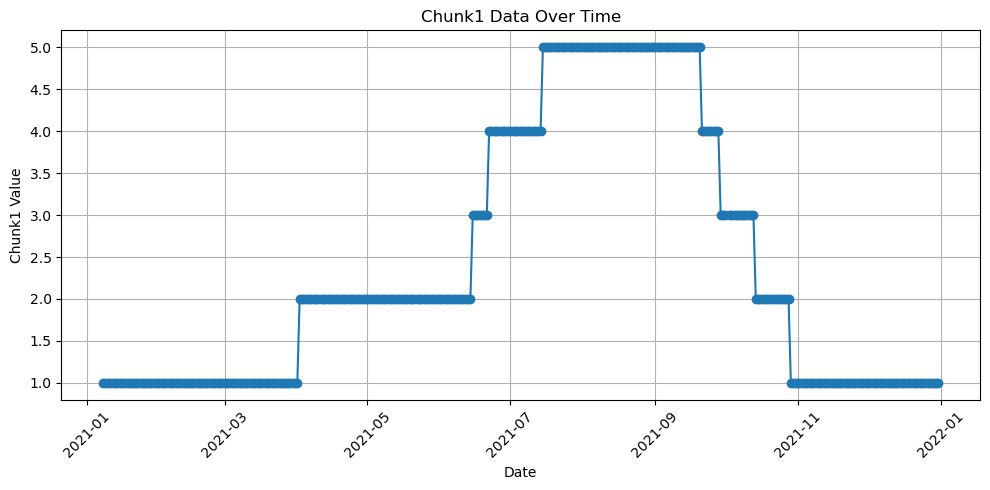

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'gdf' is your GeoDataFrame and dates are properly formatted
# Ensure the date is in datetime format
gdf['t'] = pd.to_datetime(gdf['t'])

# Filter data from January 1st to December 31st
filtered_gdf = gdf[(gdf['t'] >= '2021-01-01') & (gdf['t'] <= '2021-12-31')]

# Convert chunk1 to numeric, errors='coerce' will handle any non-numeric data
filtered_gdf['chunk1'] = pd.to_numeric(filtered_gdf['chunk1'], errors='coerce')

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(filtered_gdf['t'], filtered_gdf['chunk1'], marker='o', linestyle='-')
plt.title('Chunk1 Data Over Time')
plt.xlabel('Date')
plt.ylabel('Chunk1 Value')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout() 
plt.show()


Accuracy: 0.61
Accuracy: 0.61
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         3
           2       0.70      0.64      0.67        11
           3       0.25      0.50      0.33         6
           4       1.00      0.17      0.29         6
           5       0.73      0.73      0.73        15

    accuracy                           0.61        41
   macro avg       0.74      0.61      0.60        41
weighted avg       0.71      0.61      0.61        41



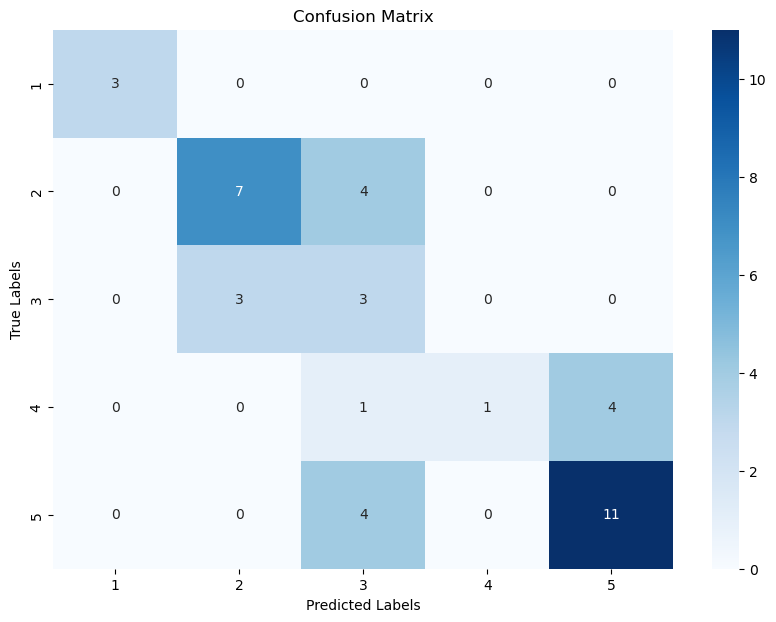

In [46]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Split the data into features and target variable
X = subset_gdf['chunk5']  # Text data
y = subset_gdf['chunk1']  # Corresponding labels

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=2000)

# Fit and transform the training data, and transform the test data
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Initialize the RandomForest classifier
classifier = RandomForestClassifier(random_state=42)

# Train the classifier
classifier.fit(X_train_tfidf, y_train)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
y_pred = classifier.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(set(y_test)), yticklabels=sorted(set(y_test)))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
import os
import requests
from bs4 import BeautifulSoup

# Base URL
url = 'https://famprod.nwcg.gov/batchout/IMSRS_from_1990_to_2022/2020/'

# Fetch the webpage
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

# Find and download files
for link in soup.find_all('a'):
    file_url = link.get('href')
    if file_url and file_url.endswith(('csv', 'pdf', 'zip', 'txt')):  # Add or remove file types as needed
        file_name = os.path.join("C:\\Users\\smdur\\OneDrive\\Desktop\\IMSR\\rawdata2020\\", os.path.basename(file_url))
        with open(file_name, 'wb') as file:
            file.write(requests.get(url + file_url).content)

In [47]:
import os
import pandas as pd
from PyPDF2 import PdfReader
import re
from datetime import datetime, timedelta

# Create a new DataFrame with dates from January 1, 2021, to December 31, 2021
start_date = datetime(2020, 1, 1)
end_date = datetime(2020, 12, 31)
date_range = pd.date_range(start=start_date, end=end_date, freq='D')
gdf = pd.DataFrame(date_range, columns=['t'])

# Format the dates for file matching
gdf['formatted_t'] = gdf['t'].dt.strftime('%Y%m%d')

# Directory path where PDF files are stored
directory_path = "C:\\Users\\smdur\\OneDrive\\Desktop\\IMSR\\rawdata2020\\"
all_files = os.listdir(directory_path)

# Initialize empty DataFrame columns for text chunks
for i in range(1, 6):
    gdf[f'chunk{i}'] = None

# Define function to extract text between two markers
def extract_text_between_markers(text, start_marker, end_marker):
    regex_pattern = f"{re.escape(start_marker)}(.*?){re.escape(end_marker)}"
    matches = re.findall(regex_pattern, text, re.DOTALL)
    return matches

# Loop through all files in the directory
matched_files = []
for file_name in all_files:
    file_date = file_name[:8]  # Extract date from file name
    if file_date in gdf['formatted_t'].values:
        pdf_path = os.path.join(directory_path, file_name)
        matched_files.append(pdf_path)

        with open(pdf_path, 'rb') as pdf_file:
            pdf_reader = PdfReader(pdf_file)
            full_text = ''.join([page.extract_text() for page in pdf_reader.pages])


        markers = [
            ("National Preparedness Level ", "National Fire Activity"),
            ("Uncontained large fires", "NIMOs committed"), # not working
            ("Fires and Acres Yesterday", "Fires and Acres Year"), # not working 
            ("Fires and Acres Year", "Predictive Services Discussion"), # not working
            ("Predictive Services Discussion:", "http://www.")
        ]

        for idx, (start, end) in enumerate(markers, 1):
            chunk = extract_text_between_markers(full_text, start, end)
            gdf.loc[gdf['formatted_t'] == file_date, f'chunk{idx}'] = ' '.join(chunk)

# Display matched files and check chunks
print("Matched Files:", matched_files)
gdf[['formatted_t', 'chunk1', 'chunk2', 'chunk3', 'chunk4', 'chunk5']].dropna()

# Assuming 'gdf' is your GeoDataFrame
gdf['chunk1'] = gdf['chunk1'].str.replace(r'\n+', '', regex=True)

gdf['chunk1'] = gdf['chunk1'].replace('None', pd.NA).ffill()
gdf.loc[:6, 'chunk1'] = 1
gdf['chunk1'] = gdf['chunk1'].ffill()


gdf['chunk1'] = gdf['chunk1'].str.strip()
gdf['chunk1'] = gdf['chunk1'].astype('category')

subset_gdf2 = gdf[gdf['chunk5'].notna()]
subset_gdf2


Matched Files: ['C:\\Users\\smdur\\OneDrive\\Desktop\\IMSR\\rawdata2020\\20200103IMSR.pdf', 'C:\\Users\\smdur\\OneDrive\\Desktop\\IMSR\\rawdata2020\\20200110IMSR.pdf', 'C:\\Users\\smdur\\OneDrive\\Desktop\\IMSR\\rawdata2020\\20200117IMSR.pdf', 'C:\\Users\\smdur\\OneDrive\\Desktop\\IMSR\\rawdata2020\\20200124IMSR.pdf', 'C:\\Users\\smdur\\OneDrive\\Desktop\\IMSR\\rawdata2020\\20200131IMSR.pdf', 'C:\\Users\\smdur\\OneDrive\\Desktop\\IMSR\\rawdata2020\\20200207IMSR.pdf', 'C:\\Users\\smdur\\OneDrive\\Desktop\\IMSR\\rawdata2020\\20200214IMSR.pdf', 'C:\\Users\\smdur\\OneDrive\\Desktop\\IMSR\\rawdata2020\\20200221IMSR.pdf', 'C:\\Users\\smdur\\OneDrive\\Desktop\\IMSR\\rawdata2020\\20200228IMSR.pdf', 'C:\\Users\\smdur\\OneDrive\\Desktop\\IMSR\\rawdata2020\\20200306IMSR.pdf', 'C:\\Users\\smdur\\OneDrive\\Desktop\\IMSR\\rawdata2020\\20200313IMSR.pdf', 'C:\\Users\\smdur\\OneDrive\\Desktop\\IMSR\\rawdata2020\\20200320IMSR.pdf', 'C:\\Users\\smdur\\OneDrive\\Desktop\\IMSR\\rawdata2020\\20200327IMSR.pd

,t,formatted_t,chunk1,chunk2,chunk3,chunk4,chunk5
2,2020-01-03,20200103,NaN,:*** 1 \nArea Command teams committed: 0 \n,,-to-Date (by Protection): \nArea BIA BLM ...,High pressu re over the western states will...
9,2020-01-10,20200110,1,:*** 4 \nArea Command teams committed: 0 \n,,-to-Date (by Protection): \nArea BIA BLM ...,A weather pattern altering low-pressure s...
16,2020-01-17,20200117,1,:*** 0 \nArea Command teams committed: 0 \n,,-to-Date (by Protection): \nArea BIA BLM ...,A strong cold front over the Continental D...
23,2020-01-24,20200124,1,:*** 0 \nArea Command teams committed: 0 \n,,-to-Date (by Protection): \nArea BIA BLM ...,
30,2020-01-31,20200131,1,:*** 0 \nArea Command teams committed: 0 \n,,-to-Date (by Protection): \nArea BIA BLM ...,Warm and dry conditions will continue acros...
...,...,...,...,...,...,...,...
338,2020-12-04,20201204,1,:*** 4 \nArea Command teams committed: 0 \n,,-to-Date (by Protection): \nArea BIA BLM ...,Strong upper -level ridging will dominate...
345,2020-12-11,20201211,1,:*** 3 \nArea Command teams committed: 0 \n,,-to-Date (by Protection): \nArea BIA BLM ...,A progressive upper -level pattern is expe...
352,2020-12-18,20201218,1,:*** 1 \nArea Command teams committed: 0 \n,,-to-Date (by Protection): \nArea BIA BLM ...,Upper -level ridging over the western U.S. a...
357,2020-12-23,20201223,1,:*** 1 \nArea Command teams committed: 0 \n,,-to-Date (by Protection): \nArea BIA BLM ...,Santa Ana winds will continue today into...


In [20]:
#subset_gdf2 = gdf[gdf['chunk5'].notna()]
#subset_gdf2 = subset_gdf2[subset_gdf2['chunk1'].notna()]


In [48]:
import pandas as pd

subset_gdf2['chunk1'].fillna('1', inplace=True)
# Remove any leading/trailing whitespaces and replace non-standard categories
subset_gdf2['chunk1'] = subset_gdf2['chunk1'].str.strip()
subset_gdf2['chunk1'] = subset_gdf2['chunk1'].replace({'': pd.NA, '3    3    3': '3'})

# Drop any rows where chunk1 is now NA (if you replaced invalid values with NA)
subset_gdf2.dropna(subset=['chunk1'], inplace=True)

# Convert chunk1 to a categorical type with defined categories 1, 2, 3, 4, 5
subset_gdf2['chunk1'] = pd.Categorical(subset_gdf2['chunk1'], categories=['1', '2', '3', '4', '5'])



Original categories: Index(['', '1', '2', '3', '3    3    3', '4', '5'], dtype='object')
Cleaned categories: Index(['1', '2', '3', '4', '5'], dtype='object')
Unique values in cleaned 'chunk1': ['1', '2', '3', '4', '5']
Categories (5, object): ['1', '2', '3', '4', '5']


C:\Users\smdur\AppData\Local\Temp\ipykernel_14744\3447456487.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_gdf2['chunk1'].fillna('1', inplace=True)
C:\Users\smdur\AppData\Local\Temp\ipykernel_14744\3447456487.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_gdf2['chunk1'] = subset_gdf2['chunk1'].str.strip()
C:\Users\smdur\AppData\Local\Temp\ipykernel_14744\3447456487.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [49]:
# Clean and prepare the text data for prediction
X_new = subset_gdf2['chunk5']#.dropna()

# Use the same TfidfVectorizer to transform the new data
X_new_tfidf = vectorizer.transform(X_new)  # Transform the new data, don't fit again

# Predict using the already trained RandomForest classifier
y_new_pred = classifier.predict(X_new_tfidf)


In [42]:
# y_true = subset_gdf2['chunk1']


# # Convert y_true to the same type as y_new_pred if necessary
# y_true = y_true.astype('category')

# # Handling missing values in y_true, if any
# y_true = y_true.dropna()

In [43]:
y_true

9      1
16     1
23     1
30     1
37     1
      ..
338    1
345    1
352    1
357    1
365    1
Name: chunk1, Length: 211, dtype: category
Categories (5, object): ['1', '2', '3', '4', '5']

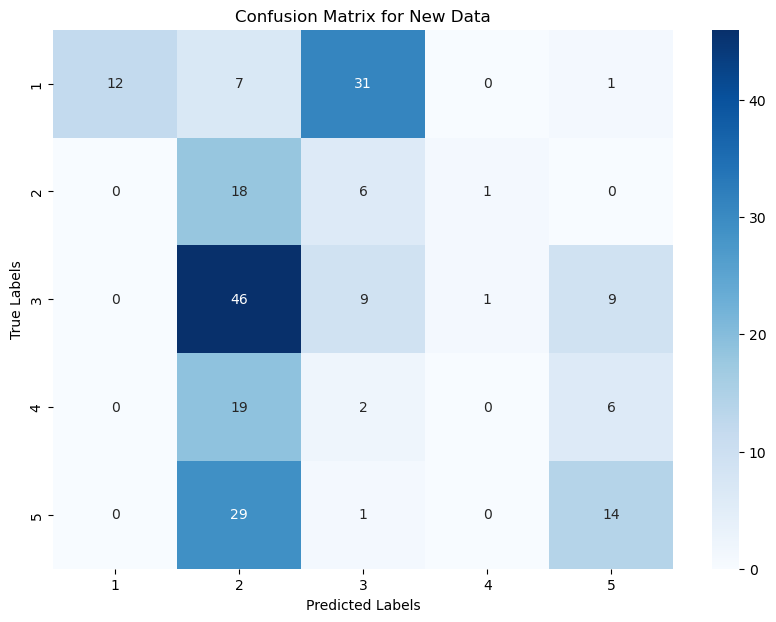

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming 'subset_gdf2['chunk1']' contains the actual labels
y_true = subset_gdf2['chunk1']

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_new_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(set(y_true)), yticklabels=sorted(set(y_true)))
plt.title('Confusion Matrix for New Data')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [54]:
import os
import requests
from bs4 import BeautifulSoup

# Base URL
url = 'https://famprod.nwcg.gov/batchout/IMSRS_from_1990_to_2022/2019/'

# Fetch the webpage
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

# Find and download files
for link in soup.find_all('a'):
    file_url = link.get('href')
    if file_url and file_url.endswith(('csv', 'pdf', 'zip', 'txt')):  # Add or remove file types as needed
        file_name = os.path.join("C:\\Users\\smdur\\OneDrive\\Desktop\\IMSR\\rawdata2019\\", os.path.basename(file_url))
        with open(file_name, 'wb') as file:
            file.write(requests.get(url + file_url).content)

In [63]:
import os
import pandas as pd
from PyPDF2 import PdfReader
import re
from datetime import datetime, timedelta

# Create a new DataFrame with dates from January 1, 2021, to December 31, 2021
start_date = datetime(2019, 1, 1)
end_date = datetime(2019, 12, 31)
date_range = pd.date_range(start=start_date, end=end_date, freq='D')
gdf = pd.DataFrame(date_range, columns=['t'])

# Format the dates for file matching
gdf['formatted_t'] = gdf['t'].dt.strftime('%Y%m%d')

# Directory path where PDF files are stored
directory_path = "C:\\Users\\smdur\\OneDrive\\Desktop\\IMSR\\rawdata2019\\"
all_files = os.listdir(directory_path)

# Initialize empty DataFrame columns for text chunks
for i in range(1, 6):
    gdf[f'chunk{i}'] = None

# Define function to extract text between two markers
def extract_text_between_markers(text, start_marker, end_marker):
    regex_pattern = f"{re.escape(start_marker)}(.*?){re.escape(end_marker)}"
    matches = re.findall(regex_pattern, text, re.DOTALL)
    return matches

# Loop through all files in the directory
matched_files = []
for file_name in all_files:
    file_date = file_name[:8]  # Extract date from file name
    if file_date in gdf['formatted_t'].values:
        pdf_path = os.path.join(directory_path, file_name)
        matched_files.append(pdf_path)

        with open(pdf_path, 'rb') as pdf_file:
            pdf_reader = PdfReader(pdf_file)
            full_text = ''.join([page.extract_text() for page in pdf_reader.pages])


        markers = [
            ("National Preparedness Level ", "National Fire Activity"),
            ("Uncontained large fires", "NIMOs committed"), # not working
            ("Fires and Acres Yesterday", "Fires and Acres Year"), # not working 
            ("Fires and Acres Year", "Predictive Services Discussion"), # not working
            ("Predictive Service Discussion:  ", "http://www.predictiveservices.nifc.gov")# also Predictive Services Discussion
        ]

        for idx, (start, end) in enumerate(markers, 1):
            chunk = extract_text_between_markers(full_text, start, end)
            gdf.loc[gdf['formatted_t'] == file_date, f'chunk{idx}'] = ' '.join(chunk)

# Display matched files and check chunks
print("Matched Files:", matched_files)
gdf[['formatted_t', 'chunk1', 'chunk2', 'chunk3', 'chunk4', 'chunk5']].dropna()

# Assuming 'gdf' is your GeoDataFrame
gdf['chunk1'] = gdf['chunk1'].str.replace(r'\n+', '', regex=True)

gdf['chunk1'] = gdf['chunk1'].replace('None', pd.NA).ffill()
gdf.loc[:6, 'chunk1'] = 1
gdf['chunk1'] = gdf['chunk1'].ffill()


gdf['chunk1'] = gdf['chunk1'].str.strip()
gdf['chunk1'] = gdf['chunk1'].astype('category')

subset_gdf2 = gdf[gdf['chunk5'].notna()]
subset_gdf2


Matched Files: ['C:\\Users\\smdur\\OneDrive\\Desktop\\IMSR\\rawdata2019\\20190201IMSR.pdf', 'C:\\Users\\smdur\\OneDrive\\Desktop\\IMSR\\rawdata2019\\20190208IMSR.pdf', 'C:\\Users\\smdur\\OneDrive\\Desktop\\IMSR\\rawdata2019\\20190215IMSR.pdf', 'C:\\Users\\smdur\\OneDrive\\Desktop\\IMSR\\rawdata2019\\20190222IMSR.pdf', 'C:\\Users\\smdur\\OneDrive\\Desktop\\IMSR\\rawdata2019\\20190301IMSR.pdf', 'C:\\Users\\smdur\\OneDrive\\Desktop\\IMSR\\rawdata2019\\20190308IMSR.pdf', 'C:\\Users\\smdur\\OneDrive\\Desktop\\IMSR\\rawdata2019\\20190315IMSR.pdf', 'C:\\Users\\smdur\\OneDrive\\Desktop\\IMSR\\rawdata2019\\20190322IMSR.pdf', 'C:\\Users\\smdur\\OneDrive\\Desktop\\IMSR\\rawdata2019\\20190329IMSR.pdf', 'C:\\Users\\smdur\\OneDrive\\Desktop\\IMSR\\rawdata2019\\20190405IMSR.pdf', 'C:\\Users\\smdur\\OneDrive\\Desktop\\IMSR\\rawdata2019\\20190412IMSR.pdf', 'C:\\Users\\smdur\\OneDrive\\Desktop\\IMSR\\rawdata2019\\20190419IMSR.pdf', 'C:\\Users\\smdur\\OneDrive\\Desktop\\IMSR\\rawdata2019\\20190426IMSR.pd

,t,formatted_t,chunk1,chunk2,chunk3,chunk4,chunk5
31,2019-02-01,20190201,1,:** ...,,,The week begins with record -setting cold acro...
38,2019-02-08,20190208,1,:** ...,,,"A pair of strong, moist systems will approach..."
45,2019-02-15,20190215,1,:** ...,,,Another p air of weakening storm systems will...
52,2019-02-22,20190222,1,:** ...,,,Another strong low pressure system will move ...
59,2019-03-01,20190301,1,:** ...,,,The Arctic Boundary over the Northern Rockies...
...,...,...,...,...,...,...,...
332,2019-11-29,20191129,1,:*** 2 \nArea Command teams committed: 0 \n,,-to-Date (by Protection): \nArea BIA BLM ...,
339,2019-12-06,20191206,1,:*** 5 \nArea Command teams committed: 0 \n,,-to-Date (by Protection): \nArea BIA BLM ...,
346,2019-12-13,20191213,1,:*** 1 \nArea Command teams committed: 0 \n,,-to-Date (by Protection): \nArea BIA BLM ...,
353,2019-12-20,20191220,1,:*** 1 \nArea Command teams committed: 0 \n,,-to-Date (by Protection): \nArea BIA BLM F...,


C:\Users\smdur\AppData\Local\Temp\ipykernel_14744\3188184962.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_gdf2['t'] = pd.to_datetime(subset_gdf2['t'])


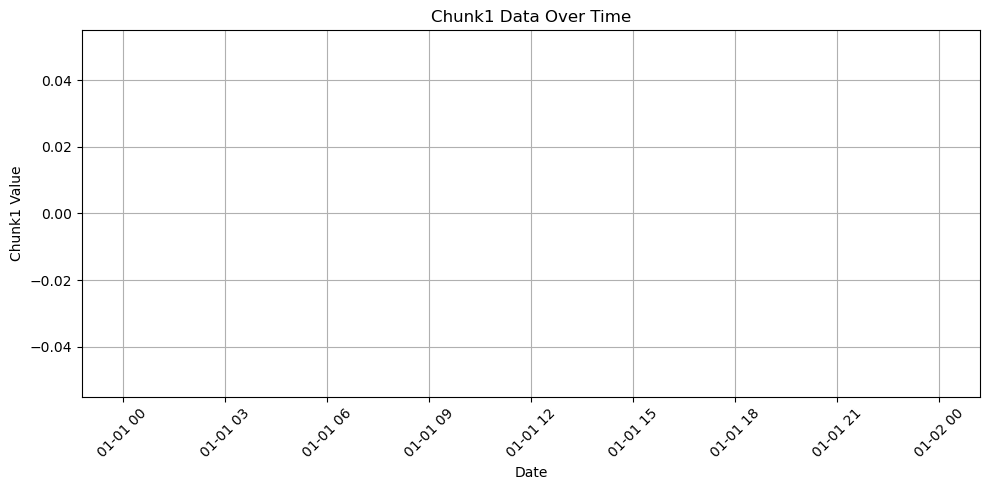

In [56]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'gdf' is your GeoDataFrame and dates are properly formatted
# Ensure the date is in datetime format
subset_gdf2['t'] = pd.to_datetime(subset_gdf2['t'])

# Filter data from January 1st to December 31st
filtered_gdf = subset_gdf2[(subset_gdf2['t'] >= '2021-01-01') & (subset_gdf2['t'] <= '2021-12-31')]

# Convert chunk1 to numeric, errors='coerce' will handle any non-numeric data
filtered_gdf['chunk1'] = pd.to_numeric(filtered_gdf['chunk1'], errors='coerce')

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(filtered_gdf['t'], filtered_gdf['chunk1'], marker='o', linestyle='-')
plt.title('Chunk1 Data Over Time')
plt.xlabel('Date')
plt.ylabel('Chunk1 Value')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout() 
plt.show()


In [ ]:
import pandas as pd

subset_gdf2['chunk1'].fillna('1', inplace=True)
# Remove any leading/trailing whitespaces and replace non-standard categories
subset_gdf2['chunk1'] = subset_gdf2['chunk1'].str.strip()
subset_gdf2['chunk1'] = subset_gdf2['chunk1'].replace({'': pd.NA, '3    3    3': '3'})

# Drop any rows where chunk1 is now NA (if you replaced invalid values with NA)
subset_gdf2.dropna(subset=['chunk1'], inplace=True)

# Convert chunk1 to a categorical type with defined categories 1, 2, 3, 4, 5
subset_gdf2['chunk1'] = pd.Categorical(subset_gdf2['chunk1'], categories=['1', '2', '3', '4', '5'])



In [ ]:
# Clean and prepare the text data for prediction
X_new = subset_gdf2['chunk5']#.dropna()

# Use the same TfidfVectorizer to transform the new data
X_new_tfidf = vectorizer.transform(X_new)  # Transform the new data, don't fit again

# Predict using the already trained RandomForest classifier
y_new_pred = classifier.predict(X_new_tfidf)
